# NBA Sports Betting Model

-----

**Regression model**

> [By: Graham Pinsent](https://twitter.com/GrahamPinsent)  
> [Linkedin](https://www.linkedin.com/in/graham-pinsent/)  
> [GitHub](https://github.com/PerryGraham)

**Tools used:** Python, scrapy,  pandas, sklearn, xgboost, matplotlib, seaborn, numpy 

The purpose of this notbook is to try to predict the [Over/Under](#explination) of an NBA game given the teams previous outcomes. I do not expect to out predict the lines given by the betting websites. However, the main goal of this project is to improve my understanding of regression analysis and get some practice with common practices. If you have any advice or improvements that you would have made please leave a comment and let me know. I'm always happy to get feedback. 

**TLDR:**  
"They are both high scoring teams, this game is going to be high" - The data from this notebook shows that this is not an accurate measurement to predict the total points of an upcomming game. There is a lot of variance when it comes to the total points scored in a match. Even the betting lines are not highly accurate. 

### TABLE OF CONTENTS:
* [Data Collection & Cleaning](#clean)
* [Data Scraping](#scrape)
* [Preprocessing & Notebook start](#pre)
* [Data Insights & Feature Engineering](#feat)
* [Models & Validation](#model)
* [Results](#results)

<sub> I tried changing many features/models/methods throughout this project and left a lot of stuff out of this notebook to make it clean, but I will make notes describing most of the things I tried. Some of the other files with cleaning and trying different features can be found on my github, link above. </sub>

-----

<a name="explination"> </a>
##### What does Over/Under mean? 

The Over/Under is betting line offered where the betting website will provide a number which you must pick if the outcome will be over or under that given number. This betting model will be refering to the most common over/under value, which is the total points (sum of both teams) scored at the end of the game. For example: if the  over/under value is 225 and you think the outcome will be lower than this, you will take the under. Then after the game team A scores 110 and team B scores 105 (110 + 105 = 115) you have won the bet because 115 is under 225. 

--------

<a name="clean"> </a>
# Data Collection & Cleaning :

* Model data downloaded from Kaggle from [Nathan Lauga](https://www.kaggle.com/nathanlauga/nba-games). 
* Betting line history data scraped from [SDQL](https://sdql.com/) using [scrapy](https://scrapy.org/)

Since the data provided was split up into a few different csv files, I had to do some matching and joining using pandas in order to add a few desired features like team records (wins, loses, gamesplayed). If you would like to see exactly what I did refer to my [github](https://github.com/PerryGraham/Betting-Model-NBA). I will only put some important snippits of the process in this notebook. 

One very important thing I added to the original dataset was the total points scored in the game, which is the target variable of this model. 

Then I restricted my data to start in 2011 -> present 

Some columns had some input errors, for example the season years had an extra number infront (eg: 2016 was in the file as 22016). Simple fix, just subtract 20,000 from all the rows. 

<a name="here"> </a>
There were some more tricky features that I tried adding, for example I wanted to have a feature that was the point total sum of the last 10 home and 10 away games for each visitor and away team. The problem here is that at the beginning of the season 20 previous games dont exist, so the solution to this was to go back a season. So I had to make a separate dataframe including one year prior to optain previous years data. After testing this feature I tried changing it to the previous 50 games (25:25, home:away) and this performed much better than only 20. Here is some of the code showing how I did this: 

Once I had the average of the previous 50 games for both teams in the matchup. I then took the mean of those two numbers. The idea here is that you should be able to see based on past performance if the team often has high scoring games or not. Then if you take the mean of both teams you should get a good value for predicting if the game will be high or low scoring. This value, along with the season, ended up being the strongest features in my model. 

-----------

# Data Scraping <a name="scrape"> </a>

I would like a baseline value to be able to compare to the accuracy of my model. So I decided to scrape previous betting line data and compare it to the outcome in order to calculate the mean absolute error of the betting line. I use the [scrapy](https://scrapy.org/) library to do this. Here is the code for the web scraper: 

From here getting the mean absolute error of the betting lines was easy: 

In [23]:
import pandas as pd 

data = pd.read_csv("bets.csv")

# The rows have duplicates because of home/away, so remove every other row
data = data[data.site == "home"]

# Adding points for both teams together
data["real_total"] = data["points"] + data["o:points"]

# Calculating the difference between the line and outcome 
data["error"] = data["real_total"] - data["total"]

# Making the error the absolute value
data["error"] = data.error.abs()

# Calculating mean absolute error between the lines and outcome 
n = len(data)
total_error = data.error.sum()
mae_lines = total_error / n

print ("MAE over last 10 years",mae_lines)

MAE over last 10 years 13.42853888937936


-------

# Preprocessing & EDA <a name="pre"> </a>

I decided to one-hot encode the team ids, this seems like the best way to handle the home and away teams. Although it adds a lot of columns to the dataframe. For the Season, I just scaled it down to start at 0. Then dropped the old columns, and the points scored per team because this is unknown untill the game is over, which would cause data leaks. 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn import preprocessing 

# Read the data
X_full = pd.read_csv("cleandata2.csv")
X_full["GAME_DATE_EST"] = pd.to_datetime(X_full["GAME_DATE_EST"],infer_datetime_format=True)
X_full = X_full.sort_values(by=["GAME_DATE_EST"], ascending=False)
X_full = X_full.reset_index()



# Label / One-Hot encoding team IDs and season
le = preprocessing.OneHotEncoder()
le2 = preprocessing.LabelEncoder()
ohe_home = le.fit_transform(X_full[["HOME_TEAM_ID"]]).toarray()
ohe_away = le.transform(X_full[["VISITOR_TEAM_ID"]]).toarray()
X_full["SEASON"] = X_full["SEASON"] - 2010

# Drop old columns
X_full = X_full.drop(columns =[
    "HOME_TEAM_ID","VISITOR_TEAM_ID", "PTS_home", "PTS_away","GAME_DATE_EST","index"], axis=1)

Here I tried a few different operations to the average point total columns to see if I could get a usefull feature from these. Turns out that the difference between the two happens to be a strong feature that helped get a bit better performance in my models. 

In [2]:
# Testing features:
X_full["diff"] = X_full["avgpointtotal_home"] - X_full["avgpointtotal_away"]
#X_full["diff"] = X_full["diff"]**2
#X_full["diff"] = X_full["diff"].abs()
#X_full["multi"] = X_full.apply(lambda row: row.avgpointtotal_home / row.avgpointtotal_away, axis=1)

#X_full["off_power_home"] = X_full["point_average_last10"] - X_full["away_point_againts_average_last10"]
#X_full["off_power_away"] = X_full["away_point_average_last10"] - X_full["point_againts_average_last10"]
#X_full["gap"] = X_full["off_power_home"].abs() + X_full["off_power_away"].abs()

In [3]:
X_full.head(5)

,SEASON,point_total,point_average_last10,point_againts_average_last10,away_point_average_last10,away_point_againts_average_last10,cgp,wins,losses,winpercent,...,losses_away,winpercen_away,hometeam-homewins,hometeam-awaywins,awayteam-homewins,awayteam-awaywins,avgpointtotal_home,avgpointtotal_away,meanpointtotal,diff
0,9,178.0,98.55,108.05,122.20,107.50,59,21,38,0.356,...,8,0.864,9,12,27,24,205.64,222.40,214.02,-16.76
1,9,266.0,116.65,109.30,107.55,107.90,59,40,19,0.678,...,23,0.617,24,16,28,9,226.24,216.72,221.48,9.52
2,9,251.0,112.35,109.50,115.95,107.40,59,40,19,0.678,...,17,0.712,23,17,23,19,219.00,221.72,220.36,-2.72
3,9,206.0,112.65,112.55,106.85,110.05,59,25,34,0.424,...,41,0.328,12,13,11,9,217.48,221.00,219.24,-3.52
4,9,236.0,120.80,117.30,116.20,109.40,59,26,33,0.441,...,13,0.776,12,14,21,24,227.04,224.28,225.66,2.76


Here we can see the layout of our data so far. I will explain what some of the columns mean:  
**point_average_last10** - is the average points scored for the home team in the last 10 games   
**points_againts_average_last10** - is the aveage points that got scored againts the home team in the past 10 games  
the next two columns are the same but for the visitor team.   
These columns should act as a way to identify strong defensive teams / strong offensive teams (which should hopefully indicate the outcome of the current game)  
**cpg** - current games played (how many games they have completed this season) (_away is the same but for the visitor team)  
last 4 columns are the ones described earlier ([here](#here))


In [4]:
X_full.describe()

,SEASON,point_total,point_average_last10,point_againts_average_last10,away_point_average_last10,away_point_againts_average_last10,cgp,wins,losses,winpercent,...,losses_away,winpercen_away,hometeam-homewins,hometeam-awaywins,awayteam-homewins,awayteam-awaywins,avgpointtotal_home,avgpointtotal_away,meanpointtotal,diff
count,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,...,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000
mean,4.934117,206.359295,100.741507,101.277327,100.718275,101.247986,38.852119,20.076290,18.776081,0.497770,...,18.735124,0.504076,11.566093,8.510197,11.823164,8.307176,201.261316,201.245986,201.253651,0.015331
std,2.463316,21.943288,5.806101,6.184010,5.794636,6.141684,25.445032,15.677251,13.778356,0.208152,...,13.736672,0.207207,9.028124,6.986531,9.047625,6.865404,9.153747,9.144523,7.344656,10.911044
min,1.000000,134.000000,83.300000,83.650000,83.500000,83.850000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,174.920000,174.920000,177.060000,-35.640000
25%,3.000000,191.000000,96.550000,96.900000,96.550000,96.750000,16.000000,7.000000,7.000000,0.364000,...,7.000000,0.371000,4.000000,3.000000,4.000000,3.000000,194.960000,194.960000,196.020000,-7.600000
50%,5.000000,205.000000,99.800000,101.500000,99.800000,101.500000,38.000000,17.000000,17.000000,0.500000,...,17.000000,0.509000,10.000000,7.000000,10.000000,7.000000,200.280000,200.280000,200.820000,-0.040000
75%,7.000000,221.000000,104.750000,105.850000,104.750000,105.850000,60.000000,30.000000,28.000000,0.636000,...,28.000000,0.639000,18.000000,13.000000,18.000000,13.000000,207.680000,207.680000,206.540000,7.635839
max,9.000000,329.000000,121.900000,123.300000,122.200000,122.300000,82.000000,73.000000,69.000000,1.000000,...,71.000000,1.000000,40.000000,34.000000,40.000000,34.000000,230.120000,229.440000,227.860000,36.000000


In [5]:
X_full.point_total.describe()

count    11915.000000
mean       206.359295
std         21.943288
min        134.000000
25%        191.000000
50%        205.000000
75%        221.000000
max        329.000000
Name: point_total, dtype: float64

One thing I notice here is that there is a lot of variance in the target variable. The standard deviation is ~22 and the range from Q1-Q3 is 30.

Checking to see the correlation between all of the features. As expected there are a lot of correlation between the features. It is important to keep this in mind when selecting models/parameters.

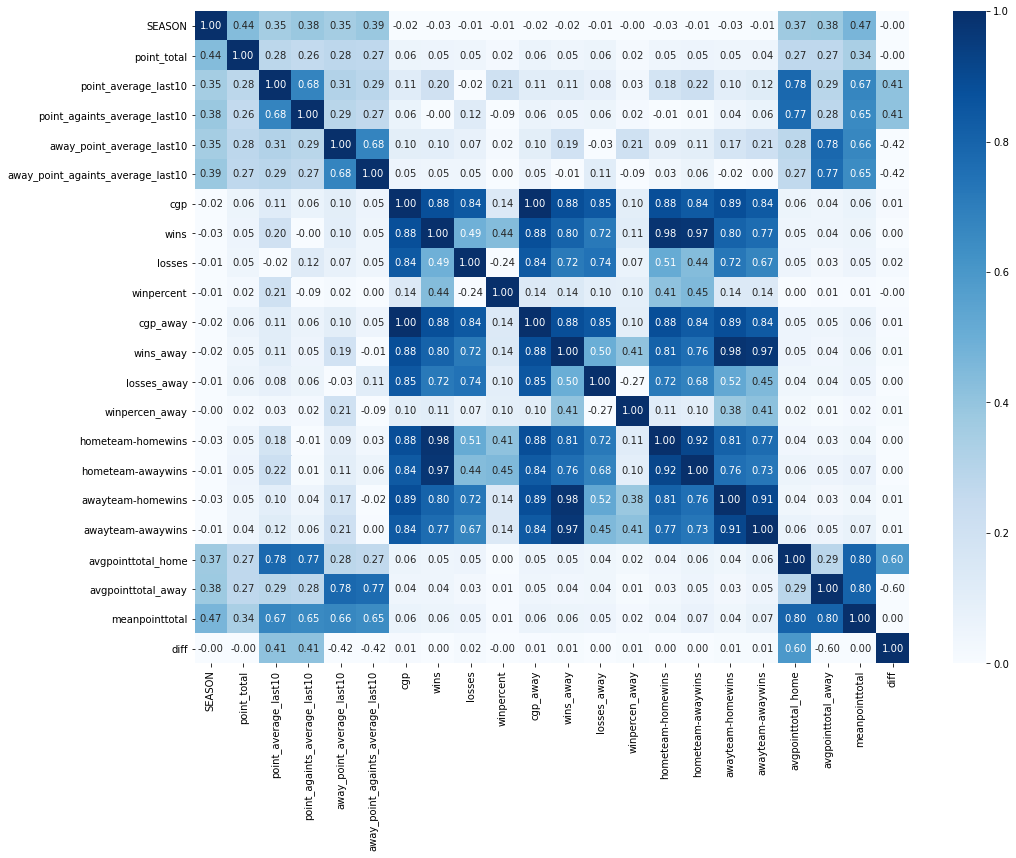

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap(X_full.corr(),
            cmap="Blues",annot=True, fmt='.2f', vmin=0);

There are some highly correlated features, these will be adressed later. The features with the highest correlation with the target are: season, meantotalpoints, and point_average_last10/away_points_average_last10

Adding on the one-hot encoded columns: 

In [7]:
ohe_home_df = pd.DataFrame(ohe_home)
ohe_away_df = pd.DataFrame(ohe_away, columns=list("abcdefghijklmnopqrstuvwxyzABCD"))
X_full = pd.concat([X_full,ohe_home_df], axis=1)
X_full = pd.concat([X_full,ohe_away_df], axis=1)
print(X_full.shape)

(11915, 82)


In [8]:
X_full.head(5)

,SEASON,point_total,point_average_last10,point_againts_average_last10,away_point_average_last10,away_point_againts_average_last10,cgp,wins,losses,winpercent,...,u,v,w,x,y,z,A,B,C,D
0,9,178.0,98.55,108.05,122.20,107.50,59,21,38,0.356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,266.0,116.65,109.30,107.55,107.90,59,40,19,0.678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,251.0,112.35,109.50,115.95,107.40,59,40,19,0.678,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,9,206.0,112.65,112.55,106.85,110.05,59,25,34,0.424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9,236.0,120.80,117.30,116.20,109.40,59,26,33,0.441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-----------

# Feature Engineering <a name="feat"> </a>

After trying a lot of different features, adjusting how many games to go back when taking the mean; here are the most successful once that I could get. I tried removing many of the features and trying different combinations. The best results are when I used more data and features. 

Lets take a look at some relationships between features and target:

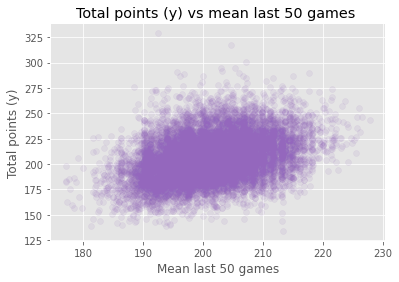

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

with plt.style.context("ggplot"):
    plt.scatter(X_full.meanpointtotal, X_full.point_total, marker="o", alpha=0.1, color='#9467bd')
    plt.xlabel("Mean last 50 games")
    plt.ylabel("Total points (y)")
    plt.title("Total points (y) vs mean last 50 games ")
fig1 = plt.figure();

There is a lot of noise and this isnt the strongest correlation. However, there is a clear trend between the total poinst scored and the average of both teams last 50 games played. 

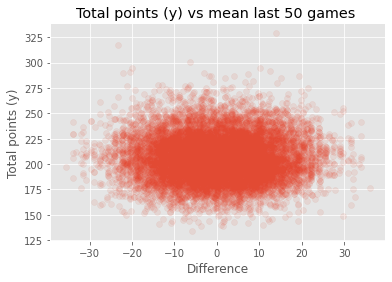

<Figure size 432x288 with 0 Axes>

In [10]:
with plt.style.context("ggplot"):
    plt.scatter(X_full["diff"], X_full.point_total, marker="o", alpha=0.1)
    plt.xlabel("Difference")
    plt.ylabel("Total points (y)")
    plt.title("Total points (y) vs mean last 50 games ")
fig2 = plt.figure();

This graph shows that there is a slight trend towards a medium scoring game when there is large difference between the two teams. But if the teams are closer in terms of their average past 50 games, then it could be a high or low scoring game. 

This trend is a bit easier to see when you plot the absolute value of the difference. 

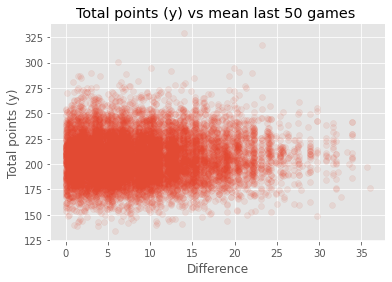

<Figure size 432x288 with 0 Axes>

In [11]:
with plt.style.context("ggplot"):
    plt.scatter(X_full["diff"].abs(), X_full.point_total, marker="o", alpha=0.1)
    plt.xlabel("Difference")
    plt.ylabel("Total points (y)")
    plt.title("Total points (y) vs mean last 50 games ")
fig3 = plt.figure();

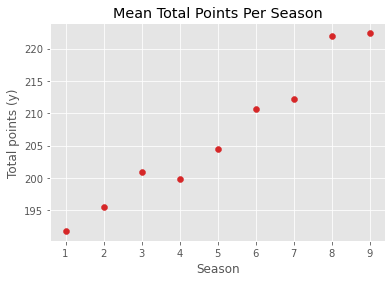

<Figure size 432x288 with 0 Axes>

In [12]:
#mean_df = X_full.copy()
#mean_df["target"] = y
season_avg = X_full.groupby(by=["SEASON"]).mean()

with plt.style.context("ggplot"):
    plt.scatter(season_avg.index, season_avg.point_total, color = "#d62728" )
    plt.xlabel("Season")
    plt.ylabel("Total points (y)")
    plt.title("Mean Total Points Per Season")
fig4 = plt.figure();

On average the amount of points scored are going up over time. Season 1 refers to 2011, all the way to 2019 (9)

--------------

# Models <a name="model"> </a>

The method for validation that I chose was doing a 90:10 train test split with no random shuffling. That is, when we are using the all of the old data to train and the newest 10% to validate. This was chosen because it was the simpilist way to acheive a good validation test for this type of model. Cross validation is not a good idea because then you would be training on data that you would not have access to if you were to use this model in practice. For example, you might be able to train on 2019 data and see that that is a high scoring season, then when predicting an early 2019 game you would get better results than you should. In theory the best method would be a leave future out validation method, because that is how the model would operate in practice. For simplicity I used 90:10. Which should yeild decent enough results for the task. 

In [13]:
from sklearn.model_selection import train_test_split


y = X_full["point_total"]
X_full = X_full.drop(columns=['point_total'])

test = len(X_full) - int(len(X_full)*0.9)

X_train = X_full.iloc[test:]
X_valid = X_full.iloc[:test]
y_train = y.iloc[test:]
y_valid = y.iloc[:test]



In [14]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error

EN = ElasticNet().fit(X_train,y_train)

pred_EN = EN.predict(X_valid)
mae_EN = mean_absolute_error(pred_EN, y_valid)
print ("mae",mae_EN)

mae 15.979896935372482


In [15]:
from sklearn.linear_model import Lasso 

ls = Lasso().fit(X_train, y_train)

pred_ls = ls.predict(X_valid)
mae_ls = mean_absolute_error(pred_ls, y_valid)
print("mae",mae_ls)

mae 15.939184128274167


In [16]:
from sklearn.linear_model import Ridge

rg = Ridge().fit(X_train, y_train)

pred_rg = rg.predict(X_valid)
mae_rg = mean_absolute_error(pred_rg, y_valid)
print("mae",mae_rg)

mae 16.059752446474615


In [17]:
from sklearn.linear_model import TheilSenRegressor

ts = TheilSenRegressor().fit(X_train, y_train)
pred_ts = ts.predict(X_valid)
mae_ts = mean_absolute_error(pred_ts,y_valid)
print("mae",mae_ts)

mae 16.070097577239068


In [18]:
#lin reg 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score

lin = LinearRegression(normalize=True, ).fit(
    X_train,y_train
)
pred_lin = lin.predict(X_valid)
mae_lin = mean_absolute_error(pred_lin, y_valid)
print("mae", mae_lin)

mae 16.06511775279205


In [19]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000).fit(
    X_train, y_train
)

pred_mlp = regr.predict(X_valid)
mae_regr = mean_absolute_error(pred_mlp, y_valid)
print("mae",mae_regr)

mae 16.590031854345042


In [20]:
import xgboost as xgb

xg = xgb.XGBRegressor(
    booster="gblinear",
    objective="reg:squarederror",
    base_score="1",
    eval_metric="cox-nloglik"
    ).fit(X_train,y_train)
pred_xg = xg.predict(X_valid)
xg_regr = mean_absolute_error(pred_xg, y_valid)
                         
print("mae",xg_regr)
print("done")

mae 16.09419615316711
done


Calculating the MAE for guessing the mean of last season every time. 

In [21]:
error = []
mean_last_season = season_avg.iloc[6,0]
for i in y_valid:
    error.append(abs(mean_last_season - i))
mae_mean = sum(error) / len(error)

print(mae_mean)
print(mean_last_season)

17.8650445808526
212.14544138929088


-----------
<a name="results"> </a>

# Results 

In [24]:
results = {"Model": ["ElasticNet","LinearRegression",
                     "MLPRegression","XGBoost",
                     "Lasso","Ridge","TheilSen",
                     "Betting lines","Guessing the mean"],
          "MAE Score": [mae_EN,mae_lin,
                       mae_regr,xg_regr,mae_ls,
                       mae_rg,mae_ts,mae_lines,
                       mae_mean]}
result_df = pd.DataFrame(data=results)
result_df = result_df.sort_values(by=["MAE Score"])
print(result_df.to_string(index=False))

             Model  MAE Score
     Betting lines  13.428539
             Lasso  15.939184
        ElasticNet  15.979897
             Ridge  16.059752
  LinearRegression  16.065118
          TheilSen  16.070098
           XGBoost  16.094196
     MLPRegression  16.590032
 Guessing the mean  17.865045


#### The best performer is the **Lasso Regressor**

This make sense because this data has a lot feautes which are correlated. The ablilty for Lasso Regression to reduce the weight of the redundant feautres to zero help produce the best predictions.  

Interpretation of the models accuracy: 

In [25]:
bttm = (1 - (mae_ls / mae_mean))*100
wttl = (1 - (mae_lines / mae_ls))*100
print("The model is {:.0f}% better than guessing the mean".format(bttm))
print("The model is {:.0f}% worse than the betting lines".format(wttl))

The model is 11% better than guessing the mean
The model is 16% worse than the betting lines


There is so much noise in the target variable that predicting the total points scored in an NBA is not easy. Using past perfromances as an estimator for point total does not work very well. "They scored 130 points last game, its going to be high again" - this data shows that this is clearly a flawed statement. Even the best models from the betting site have a mean absolute error of 13.40  points. 

##### Visualization of model predictions:

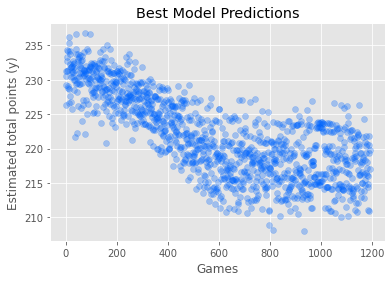

<Figure size 432x288 with 0 Axes>

In [26]:
with plt.style.context("ggplot"):
    plt.scatter(range(len(pred_ls)), pred_ls, marker="o", alpha=0.3,color = "#0066ff")
    plt.xlabel("Games")
    plt.ylabel("Estimated total points (y)")
    plt.title("Best Model Predictions")
fig6 = plt.figure();



An explination of why the predictions look like this is because the first ~400 games are from the 2018 season and the rest is the 2019 season. 

##### Visualization of actual outcomes:

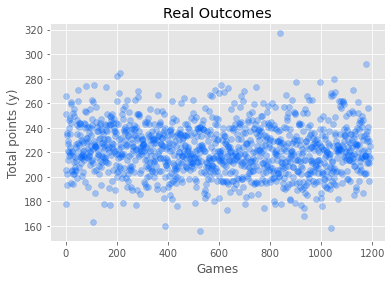

<Figure size 432x288 with 0 Axes>

In [27]:
with plt.style.context("ggplot"):
    plt.scatter(range(len(y_valid)), y_valid, marker="o", alpha=0.3, color="#0066ff")
    plt.xlabel("Games")
    plt.ylabel("Total points (y)")
    plt.title("Real Outcomes")
fig7 = plt.figure();


They look similar but the x-axis scale is much larger for the real outcomes graph. 

To see if our best model is predicting higher or lower than real outcome we can calculate the mean error without taking the absoute value: 

Average Error of Lasso: -429.6401869317762


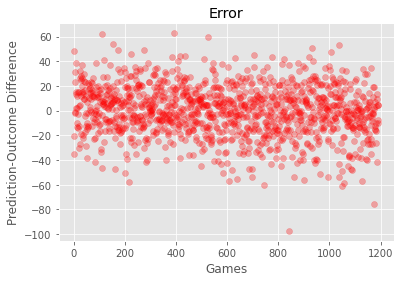

<Figure size 432x288 with 0 Axes>

In [73]:
ls = []
for i in range(len(pred_ts)):
    ls.append(pred_ls[i] - y_valid.iloc[i])
print ("Average Error of Lasso:",sum(ls))
with plt.style.context("ggplot"):
    plt.scatter(range(len(ls)), ls, marker="o", alpha=0.3, color="#ff0000")
    plt.xlabel("Games")
    plt.ylabel("Prediction-Outcome Difference")
    plt.title("Error")
fig7 = plt.figure();

A positive value means that the model on average is predicting higher than the real outcome. This can sometimes be insightful to see what the model is doing and adjust accordingly. Notice that the negative error values spread wider than the positive, this is because of the overtime games. 

**Things I would have done differently if I were to do this again**:

* Just pick one team, try to predict the total points of their games. Instead of doing every team and every match. Perhaps this would allow me to explore more features and focus in on the specific trends of that team and matchups. 

* Identify games that went to overtime, and have the total points when the regualar time ended. This could help reduce some overtime results  bias. 


Thank you 